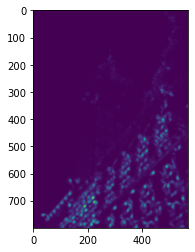

In [1]:
from scipy.ndimage import filters
from PIL import Image
from pylab import *
from numpy import *
import os

def compute_harris_response(im, sigma=3):
    """ 在一幅灰度图像中，对每个像素计算 Harris 角点检测器响应函数 """
    # 计算导数
    imx = zeros(im.shape)
    filters.gaussian_filter(im, (sigma, sigma), (0, 1), imx)
    imy = zeros(im.shape)
    filters.gaussian_filter(im, (sigma, sigma), (1, 0), imy)

    # 计算 Harris 矩阵的分量
    Wxx = filters.gaussian_filter(imx * imx, sigma)
    Wxy = filters.gaussian_filter(imx * imy, sigma)
    Wyy = filters.gaussian_filter(imy * imy, sigma)

    # 计算特征值和迹
    Wdet = Wxx * Wyy - Wxy ** 2
    Wtr = Wxx + Wyy

    return Wdet / Wtr

im = array(Image.open('../pics2/empire.jpg').convert('L'))
harrisim = compute_harris_response(im)
imshow(harrisim)
show()

starting matching


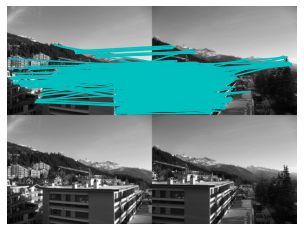

In [2]:
def get_harris_points(harrisim, min_dist=10, threshold=0.1):  # threshold阙值
    """ 从一幅 Harris 响应图像中返回角点。min_dist 为分割角点和图像边界的最少像素数目 """
    # 寻找高于阈值的候选角点
    corner_threshold = harrisim.max() * threshold
    harrisim_t = (harrisim > corner_threshold) * 1
    # 得到候选点的坐标
    coords = array(harrisim_t.nonzero()).T
    # 以及它们的 Harris 响应值
    candidate_values = [harrisim[c[0], c[1]] for c in coords]
    # 对候选点按照 Harris 响应值进行排序
    index = argsort(candidate_values)
    # 将可行点的位置保存到数组中
    allowed_locations = zeros(harrisim.shape)
    allowed_locations[min_dist:-min_dist, min_dist:-min_dist] = 1
    # 按照 min_distance 原则，选择最佳 Harris 点
    filtered_coords = []
    for i in index:
        if allowed_locations[coords[i, 0], coords[i, 1]] == 1:
            filtered_coords.append(coords[i])
            allowed_locations[(coords[i, 0] - min_dist):(coords[i, 0] + min_dist), \
            (coords[i, 1] - min_dist):(coords[i, 1] + min_dist)] = 0
    return filtered_coords


def plot_harris_points(image, filtered_coords):
    """ 绘制图像中检测到的角点 """
    figure()
    gray()
    imshow(image)
    plot([p[1] for p in filtered_coords], [p[0] for p in filtered_coords], '*')
    axis('off')
    show()


def get_descriptors(image, filtered_coords, wid=5):
    """ 对于每个返回的点，返回点周围 2*wid+1 个像素的值（假设选取点的 min_distance > wid）"""
    desc = []
    for coords in filtered_coords:
        patch = image[coords[0] - wid:coords[0] + wid + 1, coords[1] - wid:coords[1] + wid + 1].flatten()
        desc.append(patch)
    return desc


def match(desc1, desc2, threshold=0.5):
    """ 对于第一幅图像中的每个角点描述子，使用归一化互相关，选取它在第二幅图像中的匹配角点 """
    n = len(desc1[0])
    # 点对的距离
    d = -ones((len(desc1), len(desc2)))
    for i in range(len(desc1)):
        for j in range(len(desc2)):
            d1 = (desc1[i] - mean(desc1[i])) / std(desc1[i])
            d2 = (desc2[j] - mean(desc2[j])) / std(desc2[j])
            ncc_value = sum(d1 * d2) / (n - 1)
            if ncc_value > threshold:
                d[i, j] = ncc_value
    ndx = argsort(-d)
    matchscores = ndx[:, 0]
    return matchscores


def match_twosided(desc1, desc2, threshold=0.5):
    """ 两边对称版本的 match()"""
    matches_12 = match(desc1, desc2, threshold)
    matches_21 = match(desc2, desc1, threshold)
    ndx_12 = where(matches_12 >= 0)[0]
    # 去除非对称的匹配
    for n in ndx_12:
        if matches_21[matches_12[n]] != n:
            matches_12[n] = -1
    return matches_12


def appendimages(im1, im2):
    """ 返回将两幅图像并排拼接成的一幅新图像 """
    # 选取具有最少行数的图像，然后填充足够的空行
    rows1 = im1.shape[0]
    rows2 = im2.shape[0]
    if rows1 < rows2:
        im1 = concatenate((im1, zeros((rows2 - rows1, im1.shape[1]))), axis=0)
    elif rows1 > rows2:
        im2 = concatenate((im2, zeros((rows1 - rows2, im2.shape[1]))), axis=0)
    # 如果这些情况都没有，那么它们的行数相同，不需要进行填充
    return concatenate((im1, im2), axis=1)


def plot_matches(im1, im2, locs1, locs2, matchscores, show_below=True):
    """ 显示一幅带有连接匹配之间连线的图片
   输入：im1，im2（数组图像），locs1，locs2（特征位置），matchscores（match() 的输出），
    show_below（如果图像应该显示在匹配的下方）"""
    im3 = appendimages(im1, im2)
    if show_below:
        im3 = vstack((im3, im3))
    imshow(im3)
    cols1 = im1.shape[1]
    for i, m in enumerate(matchscores):
        if m > 0:
            plot([locs1[i][1], locs2[m][1] + cols1], [locs1[i][0], locs2[m][0]], 'c')
    axis('off')
    

wid = 5
im1 = array(Image.open('../pics2/crans_1_small.jpg').convert('L'))
im2 = array(Image.open('../pics2/crans_2_small.jpg').convert('L'))
harrisim = compute_harris_response(im1,5)
filtered_coords1 = get_harris_points(harrisim,wid+1)
d1 = get_descriptors(im1,filtered_coords1,wid)
harrisim = compute_harris_response(im2,5)
filtered_coords2 = get_harris_points(harrisim,wid+1)
d2 = get_descriptors(im2,filtered_coords2,wid)
print('starting matching')
matches = match_twosided(d1,d2)
figure()
gray()
plot_matches(im1,im2,filtered_coords1,filtered_coords2,matches)
show()

processed tmp.pgm to ../pics2/empire.sift


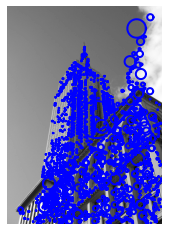

In [3]:
def process_image(imagename, resultname, params="--edge-thresh 10 --peak-thresh 5"):
    """ 处理一幅图像，然后将结果保存在文件中 """
    if imagename[-3:] != 'pgm':
        # 创建一个 pgm 文件
        im = Image.open(imagename).convert('L')
        im.save('tmp.pgm')
        imagename = 'tmp.pgm'
    cmmd = str("sift " + imagename + " --output=" + resultname + " " + params)
    os.system(cmmd)
    print('processed', imagename, 'to', resultname)


def read_features_from_file(filename):
    """ 读取特征属性值，然后将其以矩阵的形式返回 """
    f = loadtxt(filename)
    return f[:, :4], f[:, 4:]  # 特征位置，描述子


def write_features_to_file(filename, locs, desc):
    """ 将特征位置和描述子保存到文件中 """
    savetxt(filename, hstack((locs, desc)))


def plot_features(im, locs, circle=False):
    """ 显示带有特征的图像
   输入：im（数组图像），locs（每个特征的行、列、尺度和朝向）"""

    def draw_circle(c, r):
        t = arange(0, 1.01, .01) * 2 * pi
        x = r * cos(t) + c[0]
        y = r * sin(t) + c[1]
        plot(x, y, 'b', linewidth=2)
        imshow(im)

    if circle:
        for p in locs:
            draw_circle(p[:2], p[2])
    else:
        plot(locs[:, 0], locs[:, 1], 'ob')
    axis('off')
    
    
imname = 'empire.jpg'
im1 = array(Image.open('../pics2/empire.jpg').convert('L'))
process_image('../pics2/empire.jpg','../pics2/empire.sift')
l1,d1 = read_features_from_file('../pics2/empire.sift')
figure()
gray()
plot_features(im1,l1,circle=True)
show()

processed tmp.pgm to ../pics2/climbing_1_small.jpg.sift
processed tmp.pgm to ../pics2/climbing_2_small.jpg.sift
starting matching


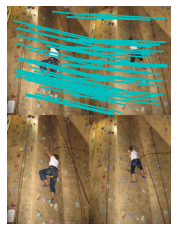

In [4]:
def match2(desc1, desc2):
    """ 对于第一幅图像中的每个描述子，选取其在第二幅图像中的匹配
   输入：desc1（第一幅图像中的描述子），desc2（第二幅图像中的描述子）"""
    desc1 = array([d / linalg.norm(d) for d in desc1])
    desc2 = array([d / linalg.norm(d) for d in desc2])

    dist_ratio = 0.6
    desc1_size = desc1.shape

    matchscores = zeros((desc1_size[0], 1), 'int')
    desc2t = desc2.T  # 预先计算矩阵转置
    for i in range(desc1_size[0]):
        dotprods = dot(desc1[i, :], desc2t)  # 向量点乘
        dotprods = 0.9999 * dotprods
        # 反余弦和反排序，返回第二幅图像中特征的索引
        indx = argsort(arccos(dotprods))
        # 检查最近邻的角度是否小于 dist_ratio 乘以第二近邻的角度
        if arccos(dotprods)[indx[0]] < dist_ratio * arccos(dotprods)[indx[1]]:
            matchscores[i] = int(indx[0])
    return matchscores


def match_twosided2(desc1, desc2):
    """ 双向对称版本的 match()"""
    matches_12 = match2(desc1, desc2)
    matches_21 = match2(desc2, desc1)
    ndx_12 = matches_12.nonzero()[0]
    # 去除不对称的匹配
    for n in ndx_12:
        if matches_21[int(matches_12[n])] != n:
            matches_12[n] = 0
    return matches_12


def appendimages(im1, im2):
    """ 返回将两幅图像并排拼接成的一幅新图像 """
    # 选取具有最少行数的图像，然后填充足够的空行
    rows1 = im1.shape[0]
    rows2 = im2.shape[0]
    if rows1 < rows2:
        im1 = concatenate((im1, zeros((rows2 - rows1, im1.shape[1]))), axis=0)
    elif rows1 > rows2:
        im2 = concatenate((im2, zeros((rows1 - rows2, im2.shape[1]))), axis=0)
    # 如果这些情况都没有，那么它们的行数相同，不需要进行填充
    return concatenate((im1, im2), axis=1)


def plot_matches2(im1, im2, locs1, locs2, matchscores, show_below=True):
    """ 显示一幅带有连接匹配之间连线的图片
   输入：im1，im2（数组图像），locs1，locs2（特征位置），matchscores（match() 的输出），
    show_below（如果图像应该显示在匹配的下方）"""
    im3 = appendimages(im1, im2)
    if show_below:
        im3 = vstack((im3, im3))
    imshow(im3)
    cols1 = im1.shape[1]
    for i, m in enumerate(matchscores):
        if m > 0:
            plot([locs1[i][0], locs2[int(m)][0] + cols1], [locs1[i][1], locs2[int(m)][1]], 'c')
    axis('off')
    


im1 = array(Image.open('../pics2/climbing_1_small.jpg'))
im2 = array(Image.open('../pics2/climbing_2_small.jpg'))
process_image('../pics2/climbing_1_small.jpg','../pics2/climbing_1_small.jpg.sift')
process_image('../pics2/climbing_2_small.jpg','../pics2/climbing_2_small.jpg.sift')
l1,d1 = read_features_from_file('../pics2/climbing_1_small.jpg.sift')
l2,d2 = read_features_from_file('../pics2/climbing_2_small.jpg.sift')
print('starting matching')
matches = match_twosided2(d1,d2)
figure()
plot_matches2(im1,im2,l1,l2,matches)
show()

starting matching


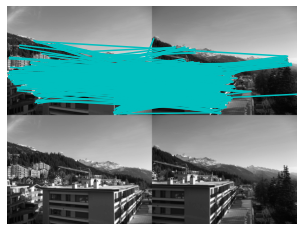

In [6]:
def my_match(desc1, desc2, threshold=0.5, max=None):
    n = len(desc1[0])
    # 点对的距离
    d = -ones((len(desc1), len(desc2)))
    for i in range(len(desc1)):
        for j in range(len(desc2)):
            d1 = (desc1[i] - mean(desc1[i])) / std(desc1[i])
            d2 = (desc2[j] - mean(desc2[j])) / std(desc2[j])
            ncc_value = sum(d1 * d2) / (n - 1)
            if ncc_value > threshold and ncc_value <= max :
                d[i, j] = ncc_value
    ndx = argsort(-d)
    matchscores = ndx[:, 0]
    return matchscores

def my_match_twosided(desc1, desc2, threshold=0.5):
    """ 两边对称版本的 match()"""
    # max = 0.7
    matches_12 = my_match(desc1, desc2, threshold, 0.7)
    matches_21 = my_match(desc2, desc1, threshold, 0.7)
    ndx_12 = where(matches_12 >= 0)[0]
    # 去除非对称的匹配
    for n in ndx_12:
        if matches_21[matches_12[n]] != n:
            matches_12[n] = -1
    return matches_12

wid = 5
im1 = array(Image.open('../pics2/crans_1_small.jpg').convert('L'))
im2 = array(Image.open('../pics2/crans_2_small.jpg').convert('L'))
harrisim = compute_harris_response(im1,5)
filtered_coords1 = get_harris_points(harrisim,wid+1)
d1 = get_descriptors(im1,filtered_coords1,wid)
harrisim = compute_harris_response(im2,5)
filtered_coords2 = get_harris_points(harrisim,wid+1)
d2 = get_descriptors(im2,filtered_coords2,wid)
print('starting matching')
matches = my_match_twosided(d1,d2)
figure()
gray()
plot_matches(im1,im2,filtered_coords1,filtered_coords2,matches)
show()


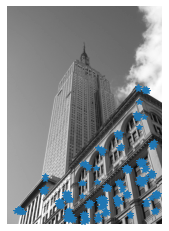

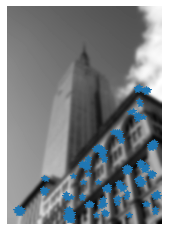

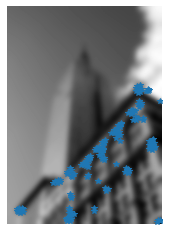

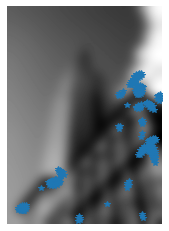

In [13]:

def my_get_harris_points(harrisim, min_dist=10, threshold=0.4):  # threshold阙值
    """ 从一幅 Harris 响应图像中返回角点。min_dist 为分割角点和图像边界的最少像素数目 """
    # 寻找高于阈值的候选角点
    corner_threshold = harrisim.max() * threshold
    harrisim_t = (harrisim > corner_threshold) * 1
    # 得到候选点的坐标
    coords = array(harrisim_t.nonzero()).T
    # 以及它们的 Harris 响应值
    candidate_values = [harrisim[c[0], c[1]] for c in coords]
    # 对候选点按照 Harris 响应值进行排序
    index = argsort(candidate_values)
    # 将可行点的位置保存到数组中
    allowed_locations = zeros(harrisim.shape)
    allowed_locations[min_dist:-min_dist, min_dist:-min_dist] = 1
    # 按照 min_distance 原则，选择最佳 Harris 点
    filtered_coords = []
    for i in index:
        if allowed_locations[coords[i, 0], coords[i, 1]] == 1:
            filtered_coords.append(coords[i])
            allowed_locations[(coords[i, 0] - min_dist):(coords[i, 0] + min_dist), \
            (coords[i, 1] - min_dist):(coords[i, 1] + min_dist)] = 0
    return filtered_coords

# 以下代码为阙值为0.4时 进行标准差分别为5 10 20的高斯模糊后的harris特征点分布
wid=5
im1 = array(Image.open('../pics2/empire.jpg').convert('L'))
im2 = filters.gaussian_filter(im, 5)
im3 = filters.gaussian_filter(im, 10)
im4 = filters.gaussian_filter(im, 20)
harrisim = compute_harris_response(im1,5)
filtered_coords1 = my_get_harris_points(harrisim,wid+1)
harrisim = compute_harris_response(im2,5)
filtered_coords2 = my_get_harris_points(harrisim,wid+1)
harrisim = compute_harris_response(im3,5)
filtered_coords3 = my_get_harris_points(harrisim,wid+1)
harrisim = compute_harris_response(im4,5)
filtered_coords4 = my_get_harris_points(harrisim,wid+1)
plot_harris_points(im1, filtered_coords1)
plot_harris_points(im2, filtered_coords2)
plot_harris_points(im3, filtered_coords3)
plot_harris_points(im4, filtered_coords4)